In [215]:
from warnings import filterwarnings

filterwarnings("ignore")

In [216]:
import pandas as pd
from pathlib import Path

path = "/home/criuser/LPI Courses/Data & IA/Final Project/store-sales-time-series-forecasting/"

In [217]:
holiday_df = pd.read_csv(path+'holidays_events.csv',
                         header=0,
                         parse_dates=['date'],
                         infer_datetime_format=True
                        )

oil_df = pd.read_csv(path+'oil.csv',
                     header=0,
                     parse_dates=['date'],
                     infer_datetime_format=True
                    )

train_df = pd.read_csv(path+'train.csv',
                       header=0,
                       parse_dates=['date'],
                       infer_datetime_format=True
                      )

In [218]:
holiday_df.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [219]:
train_df = train_df.groupby('date').sum().reset_index()

print("Shape of training set: ",train_df.shape)

train_df.tail()

Shape of training set:  (1684, 5)


,date,id,store_nbr,sales,onpromotion
1679,2017-08-11,5333291667,49005,826373.722022,14179
1680,2017-08-12,5336467191,49005,792630.535079,8312
1681,2017-08-13,5339642715,49005,865639.677471,9283
1682,2017-08-14,5342818239,49005,760922.406081,8043
1683,2017-08-15,5345993763,49005,762661.935939,10605


In [220]:
# Merge holiday col

train_df['holiday'] = [0] * train_df.shape[0]

holiday_type = { "National": 1, "Regional": 2, "Local": 3}

for idx, row in holiday_df.iterrows():
    
    if row['type'] in ['Event', 'Transfer', 'Bridge', 'Additional'] or (row['type'] == 'Holiday' and row['transferred'] == False):
        
        train_df.loc[train_df['date'] == row['date'], 'holiday'] = holiday_type[row['locale']]
        
    else:
        
        train_df.loc[train_df['date'] == row['date'], 'holiday'] = 0 # no holiday

print("Shape of training set: ",train_df.shape)

Shape of training set:  (1684, 6)


In [221]:
train_df = train_df.drop(columns=["id","store_nbr"])

In [222]:
train_df.head()

,date,sales,onpromotion,holiday
0,2013-01-01,2511.618999,0,1
1,2013-01-02,496092.417944,0,0
2,2013-01-03,361461.231124,0,0
3,2013-01-04,354459.677093,0,0
4,2013-01-05,477350.121229,0,0


In [223]:
train_df = pd.merge(train_df, oil_df, how='left', left_on=['date'], right_on = ['date'])
train_df.rename(columns = {'dcoilwtico':'oil_price'}, inplace = True)

train_df.head()

,date,sales,onpromotion,holiday,oil_price
0,2013-01-01,2511.618999,0,1,NaN
1,2013-01-02,496092.417944,0,0,93.14
2,2013-01-03,361461.231124,0,0,92.97
3,2013-01-04,354459.677093,0,0,93.12
4,2013-01-05,477350.121229,0,0,NaN


In [224]:
train_df.isna().sum()/train_df.shape[0]

date           0.000000
sales          0.000000
onpromotion    0.000000
holiday        0.000000
oil_price      0.309382
dtype: float64

# NaN imputation for oil price

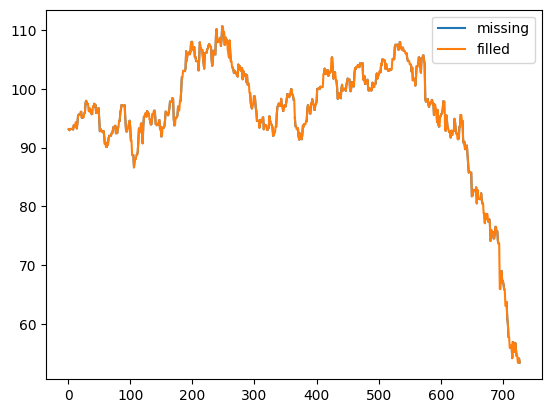

In [225]:
train_df[train_df.date.between("01-01-2013","31-12-2014")]["oil_price"].plot(label="missing")

train_df[train_df.date.between("01-01-2013","31-12-2014")]["oil_price"].interpolate(method='nearest').plot(label="filled")

plt.legend()
plt.show()

In [226]:
train_df["oil_price"] = train_df["oil_price"].interpolate(method='nearest')

train_df["oil_price"] = train_df["oil_price"].fillna(method="bfill")

# Holiday Encoding

Holiday modalities are categorical then we will use one hot encoding to see clearly the correlation

In [227]:
train_df["holiday"] = train_df["holiday"].astype("category")

In [228]:
train_df = pd.get_dummies(train_df)

In [229]:
train_df.head()

,date,sales,onpromotion,oil_price,holiday_0,holiday_1,holiday_2,holiday_3
0,2013-01-01,2511.618999,0,93.14,0,1,0,0
1,2013-01-02,496092.417944,0,93.14,1,0,0,0
2,2013-01-03,361461.231124,0,92.97,1,0,0,0
3,2013-01-04,354459.677093,0,93.12,1,0,0,0
4,2013-01-05,477350.121229,0,93.12,1,0,0,0


# Correlation matrix

<AxesSubplot: >

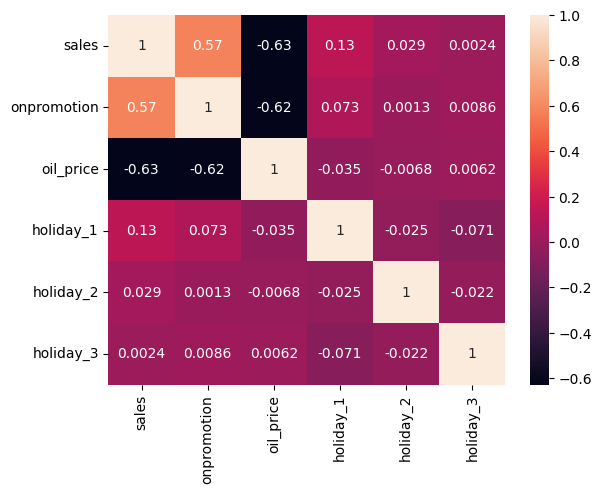

In [230]:
cor = train_df.drop(columns="holiday_0").corr()


sns.heatmap(cor, annot = True)

In [231]:
import seaborn as sns
import matplotlib.pyplot as plt

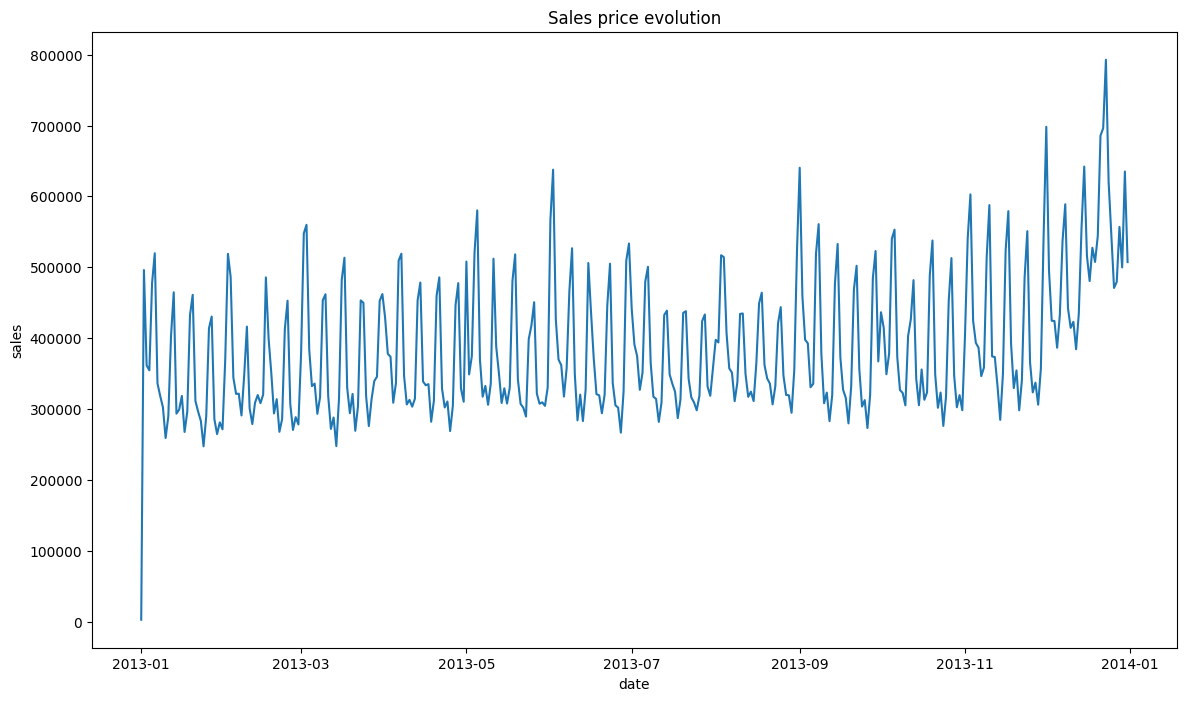

In [232]:
plt.figure(figsize=(14,8))
sns.lineplot(data=train_df[train_df.date.between("01-01-2013","31-12-2013")], x="date", y="sales")
plt.title("Sales price evolution")
plt.show()

In [233]:
train_df.to_csv("Sales_forecasting_processed_data.csv",index = False)